# Chapter 4 Exercises

From **Statistical Rethinking** by Richard McElreath

Practice problems to cement understanding of:
- Linear models
- Prior specification
- Model fitting with quap
- Posterior analysis
- Model checking

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, uniform
import sys
from pathlib import Path

# Import our quap implementation
sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

# Plotting style
plt.style.use('default')
%matplotlib inline

print('✓ Imports loaded')

✓ Imports loaded


---

## Easy Problems (4E)

Conceptual questions about model specification.

### 4E1

In the model definition below, which line is the **likelihood**?

```
yᵢ ~ Normal(μ, σ)
μ ~ Normal(0, 10)
σ ~ Exponential(1)
```

### Answer
yᵢ ~ Normal(μ, σ)

### 4E2

In the model definition just above, how many parameters are in the posterior distribution?

### Answer
2 parameters - mu and sigma.

### 4E3

Using the model definition above, write down the appropriate form of Bayes theorem that includes the proper liklihood and priors.

### Answer

**Bayes' Theorem for this model:**

$$P(\mu, \sigma \mid y) = \frac{\prod_{i} \text{Normal}(y_i \mid \mu, \sigma) \cdot \text{Normal}(\mu \mid 0, 10) \cdot \text{Exponential}(\sigma \mid 1)}{\int\int \prod_{i} \text{Normal}(y_i \mid \mu, \sigma) \cdot \text{Normal}(\mu \mid 0, 10) \cdot \text{Exponential}(\sigma \mid 1) \, d\mu \, d\sigma}$$

Or more compactly:

$$P(\mu, \sigma \mid y) = \frac{\text{Likelihood} \times \text{Prior}_{\mu} \times \text{Prior}_{\sigma}}{\text{Normalizing constant}}$$

Where:
- **Posterior**: $P(\mu, \sigma \mid y)$
- **Likelihood**: $\prod_{i=1}^{n} \text{Normal}(y_i \mid \mu, \sigma)$ (product assumes i.i.d.)
- **Prior for μ**: $\text{Normal}(\mu \mid 0, 10)$
- **Prior for σ**: $\text{Exponential}(\sigma \mid 1)$
- **Normalizing constant**: $\int\int [\text{numerator}] \, d\mu \, d\sigma$

### 4E4

In the model definition below, which line is the linear model?

```
yᵢ ~ Normal(μ, σ)
μᵢ = α + βxᵢ
α ~ Normal(0, 10)
β ~ Normal(0, 1)
σ ~ Exponential(1)
```

### Answer
μᵢ = α + βxᵢ

### 4E5

In the model definition above, how many parameters are in the posterior distribution?

### Answer
There are 3 parameters - alpha, beta and sigma. 

---

## Medium Problems (4M)

Applied problems requiring prior specification and model fitting.

### 4M1

For the model definition below, simulate observed y values from the prior (not the posterior).

```
yᵢ ~ Normal(μ, σ)
μ ~ Normal(0, 10)
σ ~ Exponential(1)
```

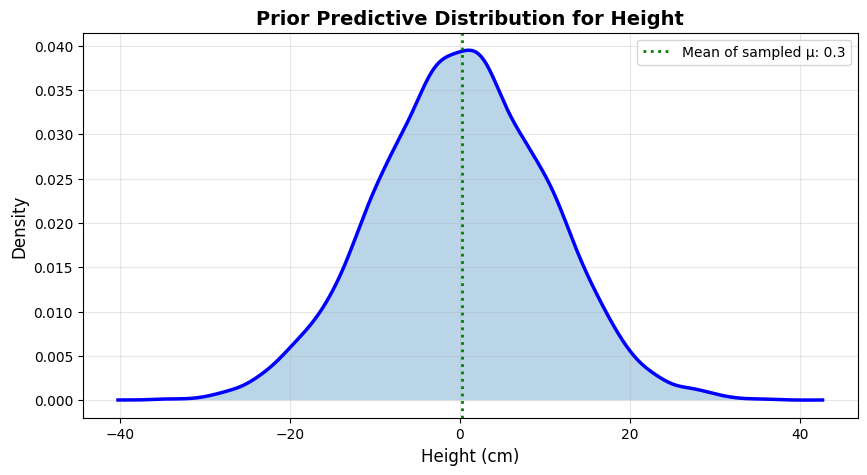

PRIOR PREDICTIVE CHECK - Do our priors make sense?

Predicted  range: [-40.2, 42.7] cm
Mean predicted height: 0.3 cm
SD of predicted heights: 10.1 cm

5th-95th percentile: [-16.6, 16.7] cm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, gaussian_kde

rng = np.random.default_rng(100) 

n = 10000
mu_mean = 0
mu_sd = 10
scale = 1

# lets take samples for mu
mu_samples = rng.normal(loc=mu_mean, scale=mu_sd, size=n)
sigma_samples = rng.exponential(scale=scale, size=n)
prior_y = rng.normal(loc=mu_samples, scale=sigma_samples, size=n)

# ============================================
# VISUALIZE THE PRIOR PREDICTIVE DISTRIBUTION
# ============================================

# Estimate density using Kernel Density Estimation (KDE)
# KDE is like a smooth histogram - it estimates the continuous density from samples
# NEW CONCEPT: KDE (Kernel Density Estimation)
# - Takes discrete samples and creates a smooth curve
# - Imagine putting a small bell curve at each data point and adding them up
# - Result: smooth density curve that approximates the true distribution
kde = gaussian_kde(prior_y)

# Create dense grid for smooth plotting
x_h = np.linspace(prior_y.min(), prior_y.max(), 600)

# Plot the prior predictive distribution
plt.figure(figsize=(10, 5))
plt.plot(x_h, kde(x_h), 'b-', linewidth=2.5)
plt.fill_between(x_h, kde(x_h), alpha=0.3)
plt.axvline(mu_samples.mean(), color='green', linestyle=':', linewidth=2,
            label=f'Mean of sampled μ: {mu_samples.mean():.1f}')
plt.title("Prior Predictive Distribution for Height", fontsize=14, fontweight='bold')
plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# ANALYZE THE RESULTS
# ============================================

print("="*70)
print("PRIOR PREDICTIVE CHECK - Do our priors make sense?")
print("="*70)
print(f"\nPredicted  range: [{prior_y.min():.1f}, {prior_y.max():.1f}] cm")
print(f"Mean predicted height: {prior_y.mean():.1f} cm")
print(f"SD of predicted heights: {prior_y.std():.1f} cm")
print(f"\n5th-95th percentile: [{np.percentile(prior_y, 5):.1f}, {np.percentile(prior_y, 95):.1f}] cm")


### 4M4

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

### Answer

#### Model Reasoning

**Likelihood:**
- Height is normally distributed around mean μ with standard deviation σ
- This tells us our likelihood is Normal

**Linear Model:**
- μᵢ = α + β × yearᵢ where year ∈ {0, 1, 2}
- **No centering needed** - α has clear interpretation as mean height at year 0
- β = growth rate (cm per year)

**Prior Choices:**
- **α (intercept)**: Starting height at year 0
  - Students likely start around 150 cm
  - Normal prior is appropriate (height can vary above/below)
  
- **β (slope)**: Growth per year
  - Must be **positive** (students grow, not shrink!)
  - LogNormal prior enforces β > 0
  - Typical growth: 2-5 cm/year for students
  
- **σ (residual SD)**: Variation not explained by year
  - Must be positive
  - After accounting for year, some individual variation remains

---

#### Complete Model Specification

**Model:**
```
hᵢ ~ Normal(μᵢ, σ)
μᵢ = α + β × yearᵢ

Priors:
α ~ Normal(150, 10)
β ~ LogNormal(Log(5), 1)
σ ~ Exponential(0.2)
```

**TODO: Fill in the ??**

**Questions to guide prior choice:**

1. **α ~ Normal(150, 10):** 
   - How much do starting heights vary?
   - What's a reasonable range? 130-170 cm?
   - Choose SD to capture this uncertainty

2. **β ~ LogNormal(Log(5), 1):**
   - What's a reasonable median growth rate? (Hint: 2-5 cm/year)
   - LogNormal(0, 1) has median = 1 cm/year
   - Could shift: LogNormal(log(3), 0.5) has median = 3 cm/year
   - How certain are you? Larger SD = more uncertainty

3. **σ ~ Exponential(1/5):**
   - How much residual variation after accounting for year?
   - Exponential(1/λ) has mean = λ
   - If mean residual ≈ 5 cm, use Exponential(1/5)
   - Or use Exponential(1) if you want mean = 1 (then interpret results)

**Think about:**
- Run prior predictive simulation to check!
- Do your priors produce reasonable heights at years 0, 1, 2?

### 4M5

Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

### Answer

**Key Information:** "Every student got taller each year"

This is **strong evidence** that β must be strictly positive. Not just positive on average, but β > 0 with very high confidence.

---

#### How This Changes Our Priors

**1. β Prior - DEFINITELY needs to change:**

Our 4M4 choice was: **β ~ LogNormal(log(5), 1)**

Problems with this prior given the new information:
- LogNormal(log(5), 1) gives 95% range: [0.67, 37] cm/year
- The lower tail (0.67 cm/year) is very small growth
- If **every** student grew, we should have higher confidence that β is meaningfully positive
- SD = 1 is too uncertain given this strong constraint

**Better choices:**

a) **Tighter around median**: β ~ LogNormal(log(3), 0.3)
   - Median: 3 cm/year (reasonable student growth)
   - 95% range: [1.7, 5.4] cm/year
   - Much more confident that growth is substantial

b) **Alternative**: β ~ LogNormal(log(4), 0.5)
   - Median: 4 cm/year
   - 95% range: [1.6, 10] cm/year
   - Slightly more uncertain than (a) but still reasonable

**Why LogNormal is now even more justified:**
- "Every student grew" = β cannot be negative
- LogNormal enforces β > 0 by construction
- We should use a tighter prior (smaller SD) to reflect our stronger belief

---

**2. α Prior - No change needed:**

α ~ Normal(150, 10) is still appropriate
- Represents starting height at year 0
- The new information doesn't tell us anything about starting height
- Only tells us about the **change** (β)

---

**3. σ Prior - Could potentially tighten:**

Original: σ ~ Exponential(1/5) with mean = 5 cm

Argument for tightening:
- If we know every student grew each year, there's less unexplained variation
- The year predictor explains growth systematically
- Could use σ ~ Exponential(1/3) with mean = 3 cm (more confident in lower residuals)

Argument against changing:
- Individual variation in growth rates still exists
- Some students grow faster/slower than others
- σ captures this individual variation, not whether growth occurs

**Verdict**: Probably keep σ as is, but could justify tightening slightly.

---

#### Updated Model

```
hᵢ ~ Normal(μᵢ, σ)
μᵢ = α + β × yearᵢ

Priors (updated):
α ~ Normal(150, 10)        # Unchanged - starting height
β ~ LogNormal(log(3), 0.3) # CHANGED - tighter, reflects "every student grew"
σ ~ Exponential(1/5)       # Unchanged - individual variation remains
```

**Key Lesson:**
Domain knowledge ("every student grew") should inform prior specification. It doesn't just tell us to use LogNormal - it tells us to use a **tighter** LogNormal that puts more mass on meaningfully positive growth rates.